In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

In [2]:
os.getcwd()
# os.chdir("C:\\Users\\user\\Desktop\\Newfreelancer\\Ben 05-12-2021\\07-aug")
Retail = pd.read_excel("Online Retail.xlsx") #reading the excel data

# lets view few rows from our data
Retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Before dropping missing and negative values
Retail.isnull().sum()
Retail.dtypes
Retail.shape

(541909, 8)

In [8]:
# After dropping missing and negative values
Retail = Retail.drop_duplicates()
Retail = Retail[(Retail['Quantity']>0)]
Retail = Retail[(Retail['UnitPrice']>0)]
Retail.shape

(524878, 8)

In [11]:
#Retail.describe().round(2)
Retail.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,349203
14,Germany,9025
13,France,8326
10,EIRE,7226
31,Spain,2479
24,Netherlands,2359
3,Belgium,2031
33,Switzerland,1841
27,Portugal,1453
0,Australia,1181


In [12]:
### CREATING THE COHORT
def all_date(data):
    return dt.datetime(data.year,data.month,1)

Retail["MonthlyInvoice"] = Retail["InvoiceDate"].apply(all_date)

Retail["MonthlyCohort"] = Retail.groupby('CustomerID')['MonthlyInvoice'].transform('min')

# We will obtain the cohort indices, which will indicate the first and final transaction of each month per year
def date_specific(data, variable):
    year = data[variable].dt.year
    month = data[variable].dt.month
    day = data[variable].dt.day
    return year, month, day

year_of_invoice, month_of_invoice, day_of_invoice = date_specific(Retail, 'MonthlyInvoice') 
year_of_cohort, month_of_cohort, day_of_cohort = date_specific(Retail, 'MonthlyCohort') 
YearlyDiff = year_of_invoice - year_of_cohort
MonthlyDiff = month_of_invoice - month_of_cohort
Retail['CohortIndex'] = YearlyDiff * 12 + MonthlyDiff + 1

#Group the data by columns CohortMonth','CohortIndex' then aggreate by column 'CustomerID'
FinalCohort = Retail.groupby(
    ['MonthlyCohort', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

#Take the cohort_data and plumb it into a Pivot Table. Setting index, columns and values as below.
CohortFreq = FinalCohort.pivot_table(index = 'MonthlyCohort',
                                       columns = 'CohortIndex',
                                       values = 'CustomerID')
CohortFreq

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
MonthlyCohort,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
### CALCULATING THE RETENTION RATE 
cohort_size = CohortFreq.iloc[:,0] #select all the rows : select the first column
retention = CohortFreq.divide(cohort_size, axis=0) #Divide the cohort by the first column
retention.round(3) # round the retention to 3 places

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
MonthlyCohort,,,,,,,,,,,,,
2010-12-01,1.0,0.366,0.323,0.384,0.363,0.398,0.363,0.349,0.354,0.395,0.374,0.503,0.266
2011-01-01,1.0,0.221,0.266,0.230,0.321,0.288,0.247,0.242,0.300,0.326,0.365,0.118,NaN
2011-02-01,1.0,0.187,0.187,0.284,0.271,0.247,0.253,0.279,0.247,0.305,0.068,NaN,NaN
2011-03-01,1.0,0.150,0.252,0.199,0.223,0.168,0.268,0.230,0.279,0.086,NaN,NaN,NaN
2011-04-01,1.0,0.213,0.203,0.210,0.197,0.227,0.217,0.260,0.073,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.190,0.173,0.173,0.208,0.232,0.264,0.095,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.174,0.157,0.264,0.231,0.335,0.095,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.181,0.207,0.223,0.271,0.112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.207,0.249,0.243,0.124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
## 3. Building RMF Model
Retail['TotalAmount'] = Retail['Quantity'] * Retail['UnitPrice']

#Recency = Latest Date - Last Inovice Data, Frequency = count of invoice no. of transaction(s), Monetary = Sum of Total 
#Amount for each customer


#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Final_Date = dt.datetime(2011,12,10)

# Obtaining RFM Modelling scores per customer
RFMScores = Retail.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Final_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,310,17,334.40
5,12352.0,36,85,2506.04
6,12353.0,204,4,89.00
7,12354.0,232,58,1079.40
8,12355.0,214,13,459.40
9,12356.0,22,59,2811.43


In [18]:
#RFMScores["Recency"].describe()
#b. Frequency Metrics
#RFMScores["Frequency"].describe()
#c Monetary Metrics
RFMScores["Monetary"].describe()

count      4338.000000
mean       2048.688081
std        8985.230220
min           3.750000
25%         306.482500
50%         668.570000
75%        1660.597500
max      280206.020000
Name: Monetary, dtype: float64

In [20]:
## 5. Building RFM Segments
# To create RFM segment, we first divide them into quantiles as follow:
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict() 

# Then use the function to return the corresponding quantile for each value
def Recency_Score(x,p,d):
    if x <= d[p][0.25]:   return 1
    elif x <= d[p][0.50]: return 2
    elif x <= d[p][0.75]: return 3
    else:                 return 4
    
def FreMon_Score(x,p,d):
    if x <= d[p][0.25]:   return 4
    elif x <= d[p][0.50]: return 3
    elif x <= d[p][0.75]: return 2
    else:                 return 1
    

#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(Recency_Score, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FreMon_Score, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FreMon_Score, args=('Monetary',quantiles,))
RFMScores.head()

#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()
Loyalty_Level = ['VIP', 'Standard', 'Economy']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 3, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores = RFMScores.sort_values('Monetary', ascending=False)
RFMScores.reset_index().head(15)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,14646.0,1,2076,280206.02,1,1,1,111,3,VIP
1,18102.0,0,431,259657.30,1,1,1,111,3,VIP
2,17450.0,8,336,194390.79,1,1,1,111,3,VIP
3,16446.0,0,3,168472.50,1,4,1,141,6,VIP
4,14911.0,1,5670,143711.17,1,1,1,111,3,VIP
5,12415.0,24,714,124914.53,2,1,1,211,4,VIP
6,14156.0,9,1395,117210.08,1,1,1,111,3,VIP
7,17511.0,2,963,91062.38,1,1,1,111,3,VIP
8,16029.0,38,241,80850.84,2,1,1,211,4,VIP
9,12346.0,325,1,77183.60,4,4,1,441,9,Standard


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

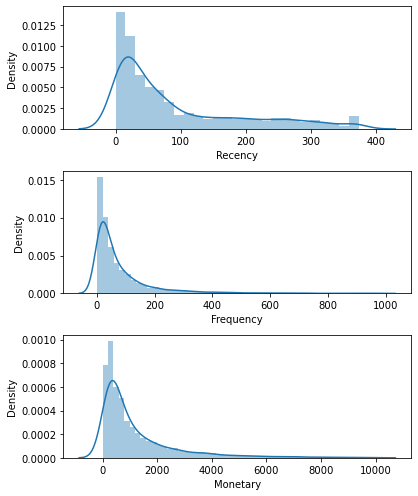

In [22]:
### K-MEANS CLUSTER
## Checking the normality of data
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [6, 7]
plt.subplot(311)
sns.distplot(RFMScores['Recency'])
plt.subplot(312)
sns.distplot(RFMScores.query('Frequency < 1000')['Frequency'])
plt.subplot(313)
sns.distplot(RFMScores.query('Monetary < 10000')['Monetary'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

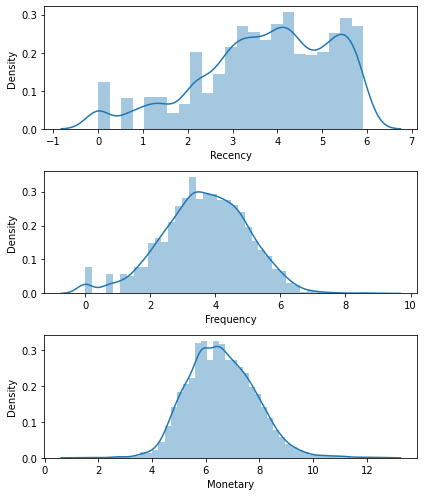

In [23]:
## Managing assymetry (Skewness) with Log transformation
#Since log can return -inf, we must convert all negative values or zeros to 1
def positive(value):
    if value <= 0:return 1
    else: return value
RFMScores['Recency'] = [positive(value) for value in RFMScores.Recency]
RFMScores['Monetary'] = [positive(value) for value in RFMScores.Monetary]

RFM_transf = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
# plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [6, 7]
plt.subplot(311)
sns.distplot(RFM_transf['Recency'])
plt.subplot(312)
sns.distplot(RFM_transf['Frequency'])
plt.subplot(313)
sns.distplot(RFM_transf['Monetary'])

Text(0.5, 1.0, 'Elbow Method For Optimal k')

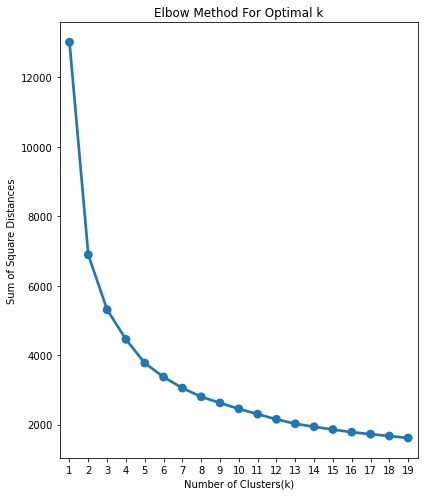

In [24]:
## Standardizing the data

DataScaler = StandardScaler()
RFM_scaled = DataScaler.fit_transform(RFM_transf)

#Transform it back to dataframe
RFM_scaled = pd.DataFrame(RFM_scaled, index = RFMScores.index, columns = RFM_transf.columns)

# Deciding Optimum number of clusters
SSDist = {}
for k in range(1,20):
    K_Means = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    K_Means = K_Means.fit(RFM_scaled)
    SSDist[k] = K_Means.inertia_

sns.pointplot(x = list(SSDist.keys()), y = list(SSDist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
14646.0,1,2076,280206.02,1,1,1,111,3,VIP,3,red
18102.0,1,431,259657.30,1,1,1,111,3,VIP,3,red
17450.0,8,336,194390.79,1,1,1,111,3,VIP,3,red
16446.0,1,3,168472.50,1,4,1,141,6,VIP,3,red
14911.0,1,5670,143711.17,1,1,1,111,3,VIP,3,red
12415.0,24,714,124914.53,2,1,1,211,4,VIP,3,red
14156.0,9,1395,117210.08,1,1,1,111,3,VIP,3,red
17511.0,2,963,91062.38,1,1,1,111,3,VIP,3,red
16029.0,38,241,80850.84,2,1,1,211,4,VIP,3,red


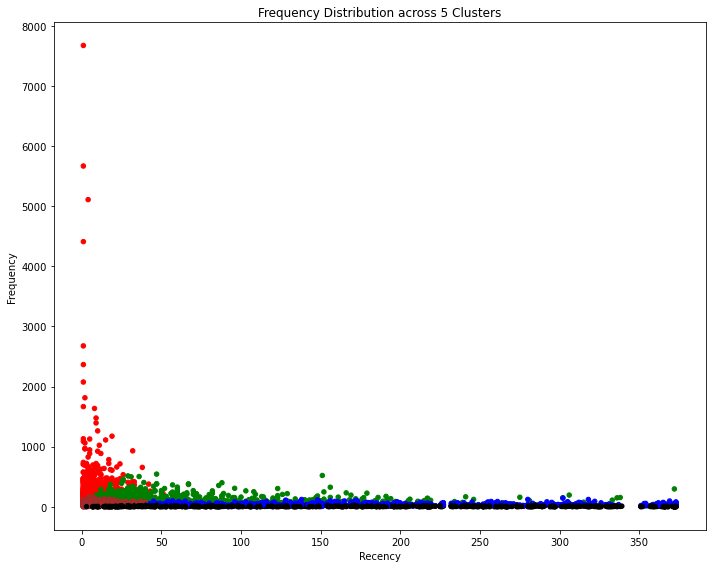

In [26]:
# Fitting K-Means clusters
KMean_clustering = KMeans(n_clusters= 5, init= 'k-means++', max_iter= 1000)
KMean_clustering.fit(RFM_scaled)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clustering.labels_
RFMScores.head()

## Analyzing clusters
Colors = ["green", "black", "brown","red","blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)
plt.title('Frequency Distribution across 5 Clusters')
RFMScores.head(10)